In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import make_circles

n_samples = 1000
X,y = make_circles(n_samples,noise = 0.03,random_state=42)

In [3]:
X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [4]:
circles = pd.DataFrame({"X1":X[:,0],"X2":X[:,1],"Label":y})


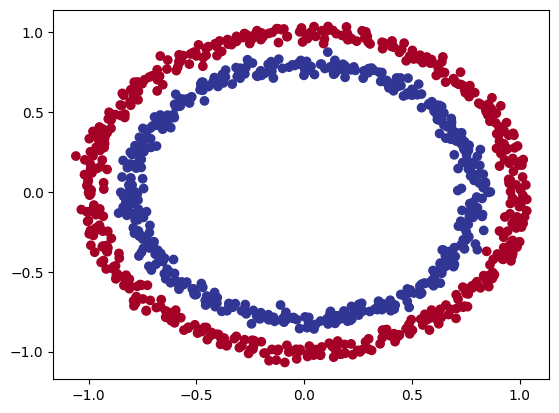

In [5]:
plt.scatter(x=X[:,0],y=X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [6]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

In [7]:
len(X_train),len(X_test),len(y_train),len(y_test)


(800, 200, 800, 200)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device : {device}")

Using device : cuda


In [52]:
class ClassifyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(in_features=2,out_features=8).double(),
            nn.ReLU(),
            nn.Linear(in_features=8,out_features=1).double(),
        )

    def forward(self,x):
        return self.layer1(x)

In [57]:
model0 = ClassifyModel().to(device)
next(model0.parameters()).device

device(type='cuda', index=0)

In [58]:
loss_fn = nn.BCEWithLogitsLoss()
lr = 0.01
optimizer = torch.optim.Adam(params=model0.parameters(),lr = lr)

In [59]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

y_train = y_train.type(torch.cuda.DoubleTensor)
y_test = y_test.type(torch.cuda.DoubleTensor)


epochs = 1000

for i in range(epochs):

    model0.train()
    y_logits= model0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits,y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model0.eval()
    with torch.inference_mode():
        test_logits = model0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,y_test)
        if i % 10 == 0:
            print(test_loss)

tensor(0.7050, device='cuda:0', dtype=torch.float64)
tensor(0.6941, device='cuda:0', dtype=torch.float64)
tensor(0.6895, device='cuda:0', dtype=torch.float64)
tensor(0.6855, device='cuda:0', dtype=torch.float64)
tensor(0.6816, device='cuda:0', dtype=torch.float64)
tensor(0.6765, device='cuda:0', dtype=torch.float64)
tensor(0.6700, device='cuda:0', dtype=torch.float64)
tensor(0.6618, device='cuda:0', dtype=torch.float64)
tensor(0.6522, device='cuda:0', dtype=torch.float64)
tensor(0.6403, device='cuda:0', dtype=torch.float64)
tensor(0.6263, device='cuda:0', dtype=torch.float64)
tensor(0.6105, device='cuda:0', dtype=torch.float64)
tensor(0.5935, device='cuda:0', dtype=torch.float64)
tensor(0.5748, device='cuda:0', dtype=torch.float64)
tensor(0.5554, device='cuda:0', dtype=torch.float64)
tensor(0.5353, device='cuda:0', dtype=torch.float64)
tensor(0.5145, device='cuda:0', dtype=torch.float64)
tensor(0.4941, device='cuda:0', dtype=torch.float64)
tensor(0.4736, device='cuda:0', dtype=torch.fl

In [45]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel())))
    X_to_pred_on = X_to_pred_on.type(torch.DoubleTensor)

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())



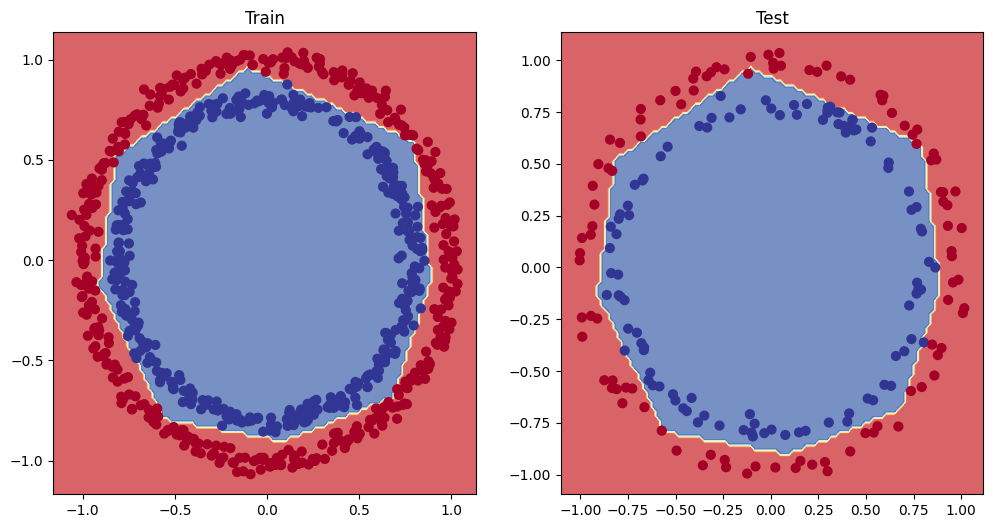

In [60]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model0,X_test,y_test)